<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Computer Engineering Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 3: Practical - Oil Price Forecasting
 <br>
<font color=696880 size=4>
            Designer: Mohammad Amanlou
    
    

**Name**: Nikan Vasei  
  
**Student Code**: 400105303

# 🛢️ Oil Price Prediction using Time Series Models 📈

This notebook is designed for students to complete tasks related to oil price prediction using different machine learning models. 🚀

## 📚 References
- 📊 [Dataset: Yahoo Finance - CL=F](https://finance.yahoo.com/quote/CL=F/history/)
- 📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)

## 1️⃣ Introduction
🔍 One of the most common applications of recurrent neural networks is **time series forecasting**. In this assignment, you will predict **crude oil prices** using four different methods. 💡

## 2️⃣ Dataset and Preprocessing (25 Points)

### 📥 2.1 Download Dataset
📌 Download the dataset from **Yahoo Finance** for `CL=F` from **2010 to the present**.
[Yahoo Finance - CL=F](https://finance.yahoo.com/quote/CL=F/history/)

### 🎯 2.2 Select Features
✅ Select the `Adj Close` column as the **main feature**.

### ⚠️ **2.3 Handle Missing Data**

You will encounter missing data (`null` values) within your dataset. Follow these detailed steps carefully to handle the missing values and create a complete, reliable dataset:

#### 📝 Step 1: Introduce Random Missing Data
- Identify all indices in the `Adj Close` column that currently have valid (non-null) data.
- Set a random seed (`np.random.seed(42)`) for reproducibility.
- Randomly select **10%** of these valid indices and set their values to `NaN`.

#### 🔍 Step 2: Identify Missing Values
- Identify all dates where at least one column has a missing value (`NaN`).
- Print the number of missing dates and the total number of dates to evaluate the extent of missingness.

#### 🔧 Step 3: Replace Missing Values
- Create a copy of the `Adj Close` column for filling purposes.
- First, apply **linear interpolation** to estimate missing values based on surrounding data points.
- Then, use backward fill (`bfill`) followed by forward fill (`ffill`) methods to handle any remaining missing values at the start or end of the dataset.

#### 🎯 Outcome:
After completing these steps, your dataset will have no missing values in the `Adj Close` column, ready for further analysis or modeling.

🛠 *Your task:* Implement the missing data handling methods below. (16 Points)

In [1]:
!gdown 1O6S3ga4Aw1Or79lvepYLDOCWglLNIo8t

Downloading...
From: https://drive.google.com/uc?id=1O6S3ga4Aw1Or79lvepYLDOCWglLNIo8t
To: /kaggle/working/CLF.csv
100%|██████████████████████████████████████| 96.9k/96.9k [00:00<00:00, 90.7MB/s]


In [2]:
import yfinance as yf
import pandas as pd

# TODO: Read the data and print 5 examples

# df = yf.download('CL=F', start='2010-01-01', auto_adjust=False, keepna=True, interval='1d')
# df = df[['Adj Close']]

# full_idx = pd.date_range(start='2010-01-01', end=pd.Timestamp.today(), freq='D')
# df = df.reindex(full_idx)
# df.reset_index(inplace=True)

# df.columns = df.columns.droplevel(level=1)
# df.reset_index(inplace=True)
# df = df[['Adj Close']]

# The code above doesn't work on kaggle (IDK why :D) so I manually downloaded the data instead

df = pd.read_csv('./CLF.csv')
df.drop(columns=df.columns[0], inplace=True)
df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Adj Close
0,NaN
1,NaN
2,NaN
3,81.510002
4,81.769997


In [3]:
# TO DO: Introduce random null
import numpy as np
np.random.seed(42)

valid_idx = df[df['Adj Close'].notna()].index
missing_idx = np.random.choice(valid_idx, size=int(len(valid_idx) * 0.1), replace=False)
df.loc[missing_idx, 'Adj Close'] = np.nan

In [4]:
# TO DO: Identify missing dates and null values
print(f"Num of missing dates:\n{df['Adj Close'].isna().sum()}")
print(f"Num of all dates:\n{len(df)}")

Num of missing dates:
2132
Num of all dates:
5606


In [5]:
# TO DO: Fill missing values using .interpolate or .fillna(method='bfill').fillna(method='ffill')  
df_filled = df['Adj Close'].copy()

df_filled = df_filled.interpolate(method='linear')
df_filled = df_filled.fillna(method='bfill').fillna(method='ffill')
df['Adj Close'] = df_filled

/tmp/ipykernel_31/3511239191.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_filled.fillna(method='bfill').fillna(method='ffill')


In [6]:
filled_data = df.copy()

### ✂️ 2.4 Train-Test Split and Normalization
- **Split** the dataset into **training and test sets** based on the ratio given in the reference paper.
- **Normalize** the data.

📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)

🛠 *Your task:* Implement the splitting and normalization below. (4 Points)

<font color='cyan'>

Train test split ratio was 70%/30% in the given paper. But we can't really use that because of the validation set. So instead we use a 60%/20%/20% split for train/val/test respectively.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
def temporal_split(series, train_ratio=0.6, val_ratio=0.2):
    #TO DO
    total_len = len(series)
    train = series.iloc[:int(total_len * train_ratio)].copy()
    val = series.iloc[int(total_len * train_ratio):int(total_len * (train_ratio + val_ratio))].copy()
    test = series.iloc[int(total_len * (train_ratio + val_ratio)):].copy()
    return train, val, test
    

train_list, val_list, test_list = [], [], []

train, val, test = temporal_split(filled_data)
train_list.append(train)
val_list.append(val)
test_list.append(test)

train_data = pd.concat(train_list)
val_data = pd.concat(val_list)
test_data = pd.concat(test_list)


scaler = MinMaxScaler()
train_data['Adj Close'] = scaler.fit_transform(train_data[['Adj Close']])
val_data['Adj Close'] = scaler.transform(val_data[['Adj Close']])
test_data['Adj Close'] = scaler.transform(test_data[['Adj Close']])
print("Training data sample:")
print(train_data.head())
print("Testing data sample:")
print(test_data.head())

Training data sample:
   Adj Close
0   0.628977
1   0.628977
2   0.628977
3   0.628977
4   0.631952
Testing data sample:
      Adj Close
4484   0.847448
4485   0.889219
4486   0.920119
4487   0.923724
4488   0.927329


### 📊 2.5 Data Visualization
- **Plot a histogram** similar to **Figure 6** in the reference paper, showing the **distribution of oil prices**.

🛠 *Your task:* Implement the histogram plot below. (5 Points)

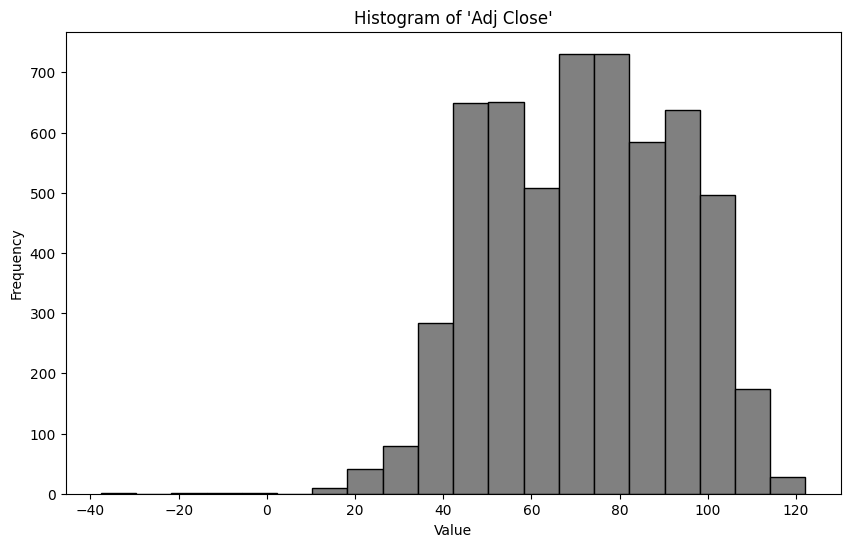

In [8]:
# TO DO: Plot histogram of 'Adj Close'
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.hist(filled_data['Adj Close'], color='grey', edgecolor='black', bins=20)
plt.title("Histogram of 'Adj Close'")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

## 3️⃣ Implementing Deep Learning Models 🤖 (60 Points)

The reference paper utilizes **three models** for time series forecasting:
- `RNN`
- `LSTM`
- `GRU`

📌 **Train** each model using the **hyperparameters** given in **Table 4** of the paper.
📌 Use `Mean Square Error (MSE)` as the **loss function**.

📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)


### Important Details & Clarifications

- **What to Predict?**  
  The goal is to predict **the actual next-day price** (regression problem), rather than just identifying price increase or decrease.
  
- **Input/Output Structure:**  
  - **Input:** A window of \( k \) consecutive daily prices (e.g., 50 days).  
  - **Output:** The predicted price for the next day.
  
- **How to Evaluate?**  
  Use the four metrics (RMSE, MAE, MAPE, \( R^2 \)) to gauge how accurately your model tracks the real price values.

- **Target Accuracy:**  
  Your accuracy might differ from the paper’s due to factors like data splitting, normalization, or different random seeds. However, aim to closely replicate the paper’s results or provide justifications for any discrepancy.

**Final Deliverables:**
1. **All four trained models** (RNN, LSTM, GRU).  
2. **Comparison plots** of predicted vs. actual values (in both normalized and original price scales, if desired).  
3. **Performance metrics** (RMSE, MAE, MAPE, \( R^2 \)) for each model, presented in a table or a concise summary.


🛠 *Your task:* Implement these models below. (30 Points)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def create_sequences(data, window_size):
    #TO DO
    sequences, targets = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])

    X = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1) # d, w, 1
    y = torch.tensor(targets, dtype=torch.float32).unsqueeze(1) # d, 1
    return X, y

window_size = 50
#TO DO: make test and train loader

train_seq = train_data['Adj Close'].values
val_seq = val_data['Adj Close'].values
test_seq = test_data['Adj Close'].values

X_train, y_train = create_sequences(train_seq, window_size)
X_val, y_val = create_sequences(val_seq, window_size)
X_test, y_test = create_sequences(test_seq, window_size)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

batch_size = 100 # same as the paper
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train batches: 34, Val batches: 11, Test batches: 11


/tmp/ipykernel_31/2798806906.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1) # d, w, 1


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# LSTM
class LSTMModel(nn.Module):
    #TO DO
    def __init__(self, input_size=1, hidden_size=512, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size # same as the paper
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # (b, w, hidden_size)
        out = self.fc(out[:, -1, :])   # (b, 1)
        return out

lstm_model = LSTMModel()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

def train_model(model, train_loader, test_loader, epochs=50):
    #TO DO
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                val_losses.append(loss_fn(preds, y_batch).item())
                
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Val Loss: {torch.tensor(val_losses).mean():.4f}")

train_model(lstm_model, train_loader, test_loader)

Epoch 0, Val Loss: 0.0757
Epoch 10, Val Loss: 0.0092
Epoch 20, Val Loss: 0.0032
Epoch 30, Val Loss: 0.0056
Epoch 40, Val Loss: 0.0029


In [12]:
class RNNModel(nn.Module):
    #TO DO
    def __init__(self, input_size=1, hidden_size=512, num_layers=1, nonlinearity='tanh'):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size # same as the paper (although the paper didn't really mention RNN)
        self.num_layers = num_layers
        self.rnn = nn.RNN(
            input_size,
            hidden_size, 
            num_layers,
            nonlinearity=nonlinearity,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

rnn_model = RNNModel()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train_model(rnn_model, train_loader, test_loader)


Epoch 0, Val Loss: 0.0533
Epoch 10, Val Loss: 0.0965
Epoch 20, Val Loss: 0.0719
Epoch 30, Val Loss: 0.1700
Epoch 40, Val Loss: 0.1484


In [13]:
# GRU
class GRUModel(nn.Module):
    #TO DO
    def __init__(self, input_size=1, hidden_size=512, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(
            input_size, 
            hidden_size, 
            num_layers,
            batch_first=True, 
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

gru_model = GRUModel()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
train_model(gru_model, train_loader, test_loader)

Epoch 0, Val Loss: 0.0361
Epoch 10, Val Loss: 0.0025
Epoch 20, Val Loss: 0.0038
Epoch 30, Val Loss: 0.0058
Epoch 40, Val Loss: 0.0022


### 📈 3.1 Prediction and Evaluation
1. **Prediction:** After training, generate predictions for the test set (i.e., predict the next-day price based on the preceding \( k \) days).
2. **Visualization:** **Plot the predicted values** alongside the **actual values** for each model. This comparison helps in visually assessing each model’s performance.

🛠 **Your Task:** Implement the **visualization of predictions** (15 Points).

In [14]:
# Predictions
def predict(model, data_loader):
    #TO DO
    model.to(device)
    model.eval()
    
    preds_list, gt = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            preds_list.append(preds.cpu())
            gt.append(y_batch)
            
    preds_all = torch.cat(preds_list).squeeze().numpy()
    true_all = torch.cat(gt).squeeze().numpy()
    
    return preds_all, true_all

#TO DO: predict real outputs
lstm_preds, lstm_gt = predict(lstm_model, test_loader)
rnn_preds, rnn_gt = predict(rnn_model, test_loader)
gru_preds, gru_gt = predict(gru_model, test_loader)

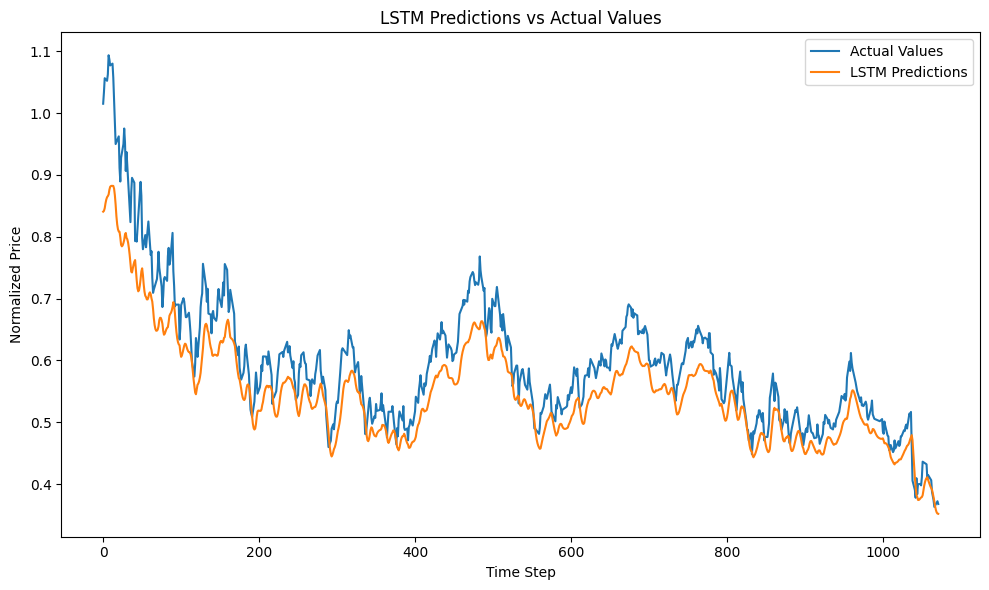

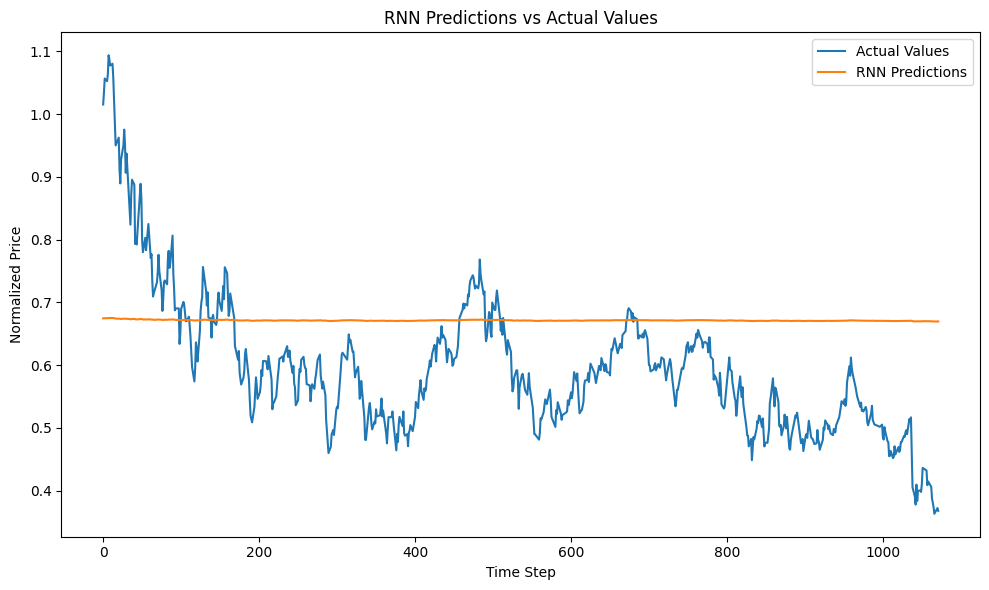

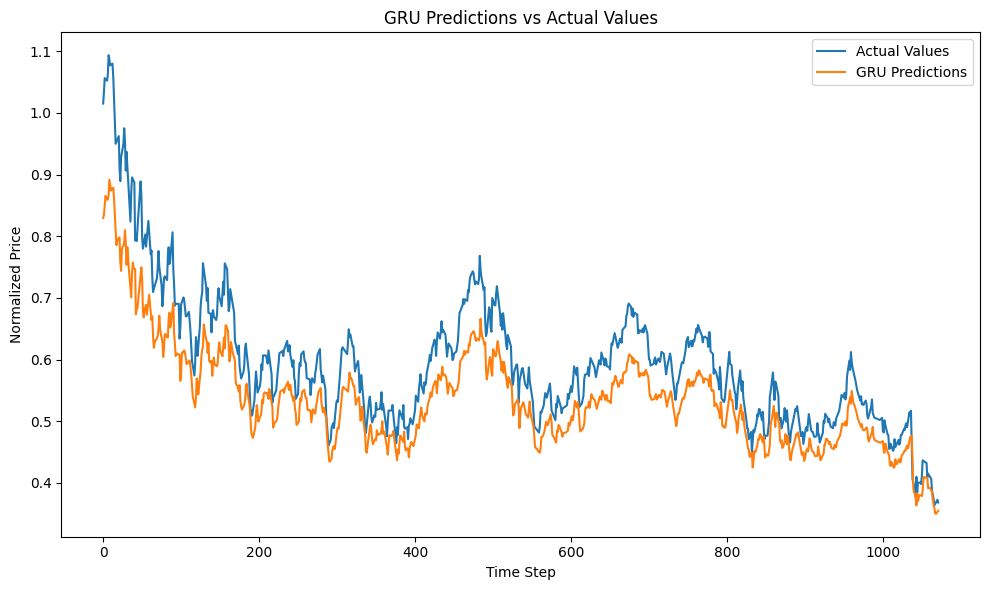

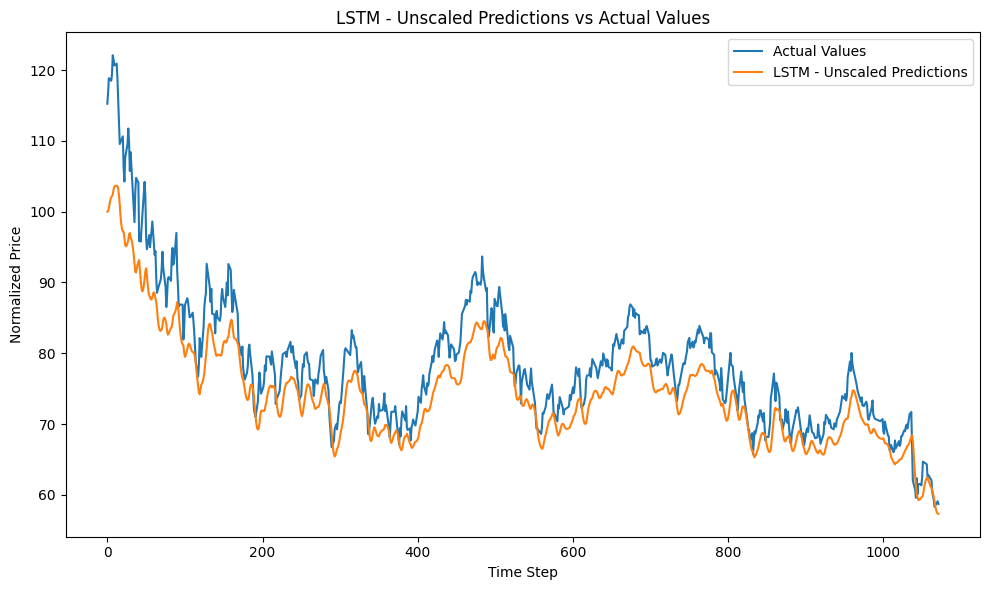

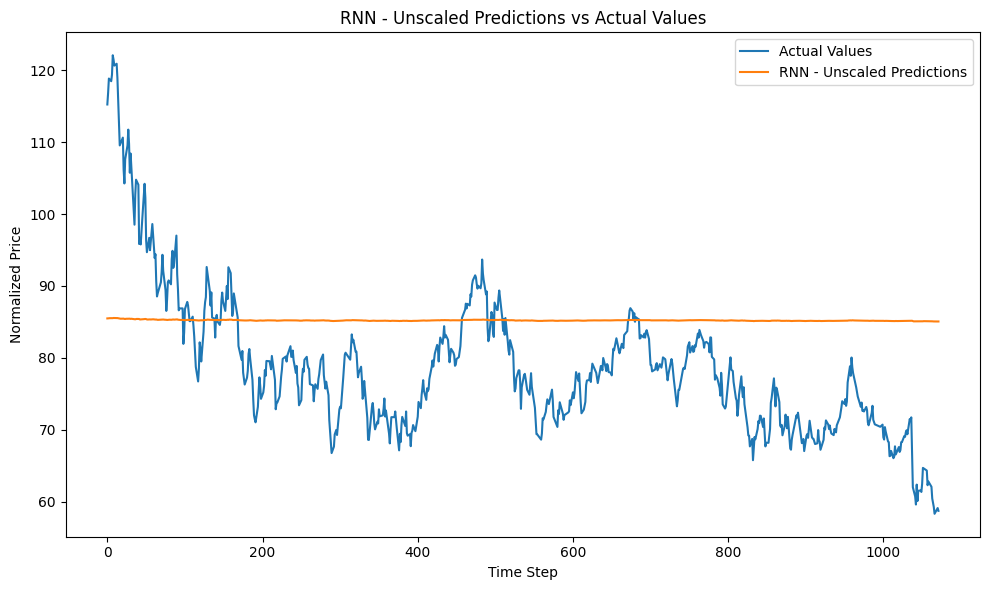

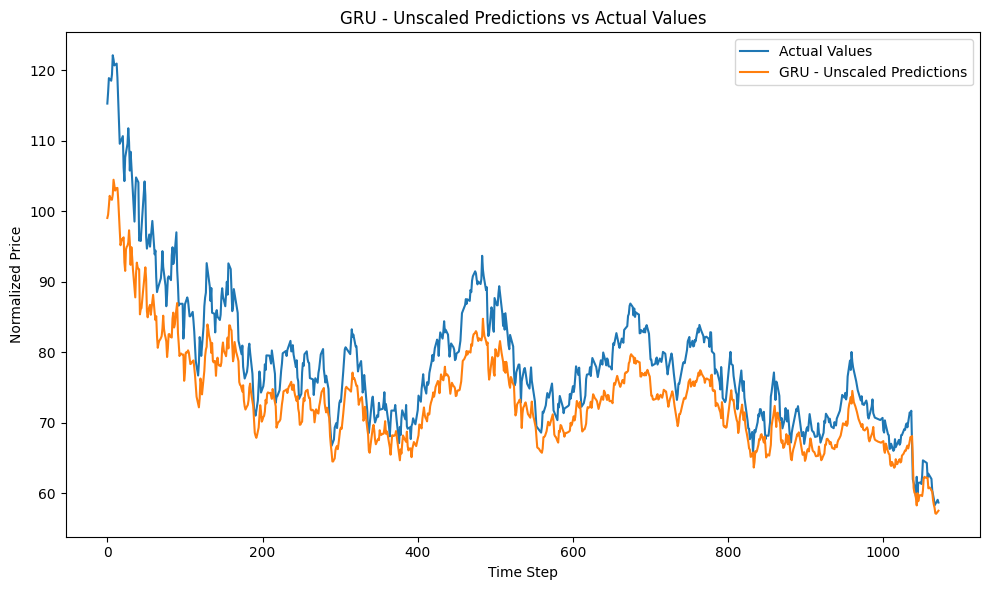

In [16]:
def plot_predictions(predictions, actual, model_name):
    #TO DO
    plt.figure(figsize=(10, 6))
    
    plt.plot(actual, label='Actual Values')
    plt.plot(predictions, label=f'{model_name} Predictions')
    plt.title(f'{model_name} Predictions vs Actual Values')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

#TO DO: plot all models predictions on all data
plot_predictions(lstm_preds, lstm_gt, "LSTM")
plot_predictions(rnn_preds, rnn_gt, "RNN")
plot_predictions(gru_preds, gru_gt, "GRU")

lstm_preds_unscaled = scaler.inverse_transform(lstm_preds.reshape(-1, 1)).flatten()
rnn_preds_unscaled = scaler.inverse_transform(rnn_preds.reshape(-1, 1)).flatten()
gru_preds_unscaled = scaler.inverse_transform(gru_preds.reshape(-1, 1)).flatten()

lstm_gt_unscaled = scaler.inverse_transform(lstm_gt.reshape(-1,1)).flatten()
rnn_gt_unscaled = scaler.inverse_transform(rnn_gt.reshape(-1,1)).flatten()
gru_gt_unscaled = scaler.inverse_transform(gru_gt.reshape(-1,1)).flatten()

plot_predictions(lstm_preds_unscaled, lstm_gt_unscaled, "LSTM - Unscaled")
plot_predictions(rnn_preds_unscaled, rnn_gt_unscaled, "RNN - Unscaled")
plot_predictions(gru_preds_unscaled, gru_gt_unscaled, "GRU - Unscaled")

### 📊 3.2 Error Metrics
📌 Explain the following **error metrics** used in the paper:
- `RMSE` (Root Mean Square Error)
- `MAE` (Mean Absolute Error)
- `MAPE` (Mean Absolute Percentage Error)
- `R-Squared` (Coefficient of Determination)

**📌 Instruction:**  
Explain each of these error metrics and calculate them for **each model** (RNN, LSTM, GRU). Compare your results with the paper’s findings to see how closely they match.

🛠 *Your task:* Implement the evaluation metrics below. (15 Points)

<font color='cyan'>

- `RMSE (Root Mean Square Error)`: It's quite sensitive to large errors, in the same units as our target and thus is also quite sensitive to outliers (because they cause large errors). ($y_i$ = ground truth, $\hat{y}_i$ = prediction)
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

- `MAE (Mean Absolute Error):` As it averages absolute deviations, we can say that it's kind of more robust to outliers than methods like RMSE (also because it weights all of the errors equally). ($y_i$ = ground truth, $\hat{y}_i$ = prediction)
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

- `MAPE (Mean Absolute Percentage Error):` It's quite the same as MAE but it expresses error as a percentage of the true value and thus it could be useful if we want something interpretable. Besides that is has division-by-zero problems so we should be cautious with it. ($y_i$ = ground truth, $\hat{y}_i$ = prediction)
$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

- `R-Squared (Coefficient of Determination):` In simple terms it explains the fraction of variance (1 is perfect, 0 is baseline mean predictor, and negative if you do worse than the mean). ($y_i$ = ground truth, $\hat{y}_i$ = prediction)
$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$


### Comparison

- If we want to compare our losses with the paper ones, we can say that respectively they're quite the same, (e.g., for LSTM, RMSE is nearly twice the amount of MAE, and MAPE is somewhere about 3% to 4%). But of course they have some gaps (especially in RNN) because first of all the data that the paper uses is different from the one that we have used, and secondly the parameters of the models that the paper uses (except the embedding dimension which is the same 512) are different. Also there are some randomnesses that also effect those results.

  Overall we can say that our findings is quite similar to the paper, because LSTM and GRU perform much better than RNN and are quite the same as each other, but of course there are some gaps between our values and paper's values.

In [17]:
# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(predictions, actual):
    #TO DO
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)
    r2 = r2_score(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return (rmse, mae, r2, mape)

print("RNN Metrics (Unscaled):", calculate_metrics(rnn_preds, rnn_gt))
print("LSTM Metrics (Unscaled):", calculate_metrics(lstm_preds, lstm_gt))
print("GRU Metrics (Unscaled):", calculate_metrics(gru_preds, gru_gt))

RNN Metrics (Unscaled): (0.1362076, 0.11419857, -0.4283462017036943, 20.701411366462708)
LSTM Metrics (Unscaled): (0.05757755, 0.047663476, 0.7447667654907419, 7.538960874080658)
GRU Metrics (Unscaled): (0.0675295, 0.059471805, 0.6489104490623283, 9.489564597606659)


In [18]:
!gdown 1Kh62Uo0e5LXUiLZZJPRg7jY3WRgWNmGK

Downloading...
From: https://drive.google.com/uc?id=1Kh62Uo0e5LXUiLZZJPRg7jY3WRgWNmGK
To: /kaggle/working/CLF-Full.csv
100%|█████████████████████████████████████████| 365k/365k [00:00<00:00, 105MB/s]


In [19]:
data = pd.read_csv('./CLF-Full.csv')
data.head()

,Adj Close,Close,High,Low,Open,Volume
0,81.510002,81.510002,81.680000,79.629997,79.629997,263542
1,81.769997,81.769997,82.000000,80.949997,81.629997,258887
2,83.180000,83.180000,83.519997,80.849998,81.430000,370059
3,82.660004,82.660004,83.360001,82.260002,83.199997,246632
4,82.750000,82.750000,83.470001,81.800003,82.650002,310377


In [20]:
# Fill missing values for all features
filled_data = data.copy()
for column in ['Open', 'High', 'Low', 'Volume', 'Adj Close']:
    filled_data[column] = filled_data[column].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

# WE WILL USE THESE IN ARIMA PART AS INPUTS OF MODELS
train_data = filled_data.iloc[:-int(0.3 * len(filled_data))]
test_data = filled_data.iloc[-int(0.3 * len(filled_data)):]
train_target = train_data['Adj Close']
train_exog = train_data[['Open', 'High', 'Low', 'Volume']]
test_target = test_data['Adj Close']
test_exog = test_data[['Open', 'High', 'Low', 'Volume']]

# ADF Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_data['Adj Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")
print("The series is stationary." if result[1] < 0.05 else "The series is not stationary.")

/tmp/ipykernel_31/2738882515.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_data[column] = filled_data[column].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


ADF Statistic: -1.3549505858315058
p-value: 0.6036728634578764
Critical Values: {'1%': -3.432776068405479, '5%': -2.862611858714308, '10%': -2.5673405860421004}
The series is not stationary.


## 4️⃣ ARIMA Model 📉 (15 Points)

📌 Explain the **difference** between `ARIMA` and `SARIMA` models.

<font color='cyan'>

- `ARIMA (AutoRegressive Integrated Moving Average)` captures three fundamental dynamics of a univariate time series. First, the ***AutoRegressive (AR)*** part regresses the series on its own past values. Second, the ***Integrated (I)*** part differences the series one or more times to remove trends and achieve stationarity. Third, the ***Moving‐Average (MA)*** part expresses the current value as a function of past forecast errors. By combining those steps, ARIMA works beautifully when we have no obvious periodic behaviors in our data.

- `SARIMA (Seasonal ARIMA)` on the other hand, extends ARIMA to explicitly model seasonal patterns and periods. In addition to the non‐seasonal (p, d, q) ARIMA orders, SARIMA adds a ***seasonal triple (P, D, Q)*** that operates on lags spaced by the season length—in our case, 12 months. In effect, SARIMA simultaneously fits a standard ARIMA on the differenced series and another ARIMA on the seasonally differenced series, allowing it to capture both short‐term shock responses and regular, seasonal rebounds. Thus SARIMA works beautifully when we have some periodic behaviors in our data.

📌 List the **advantages** and **limitations** of `ARIMA`.

- `Advantages`: ARIMA is very simple and also interpretable. We also saw that in the code, that by using only 3 variables (p, d, q) we can describe so many different kinds of behaviors. e.g., we can choose the momentum of recent trends, or long-run trend just by playing with AR or I respectively.

- `Disadvantages`: But we should also consider that ARIMA assumes linearity in its calculations, so it doesn't work that well when the true dynamics of the system involve different non-linearities or thresholds. Another thing that ARIMA assumes is stationarity, thus if our data has complex volatility again it performs poorly.

📌 Explain the **mathematical formulation** of `ARIMA`, including its **parameters**.

- Formally, an $ARIMA(p, d, q)$ model says that the $d$-th differenced series,
    $$
    \Delta^d y_t = y_t - y_{t-1},
    $$
    obeys the equation:
    $$
    \Delta^d y_t = \phi_1\Delta^d y_{t-1} + \phi_2\Delta^d y_{t-2} + \dots + \phi_p\Delta^d y_{t-p} + \theta_1\epsilon_{t-1} + \dots + \theta_q\epsilon_{t-q} + \epsilon_t
    $$

    where:
    - $p$: # of AR terms (the amount of past values that the model uses)
        - $\phi_p$: coefficients of AR terms
    - $d$: # of times related to I term (to make the point stationary)
    - $q$: # of MA terms (the amount of prediction or forecast errors that the model uses)
        - $\theta_q$: coefficients of MA terms 

📌 Determine the **optimal parameters** for `ARIMA` and **report the results**.

- We did that using the `auto_arima` function. It evaluates different configs using different combinations of the variables and then chooses the best one using a criteria like AIC (which we have used in our code). Based on that we have found out that the best possible order for an ARIMA model to be used in this example is (0, 1, 1).

📌 Compare the results with **Table 6** from the paper.

- The paper uses ARIMA (1, 1, 5) and ARIMA (2, 2, 2) which is quite different from the one that we have used, and its probably because of the differences in our data, our parameters and other tunable things. But metric-wise ARIMA models perform quite nicely both in our work and paper's work (even outperforms LSTM and GRU on some of the datasets).

📄 [Reference Paper](https://www.ijournalse.org/index.php/ESJ/article/view/21497)

🛠 *Your task:* Implement the ARIMA model below.

In [21]:
# Train ARIMA model using auto_arima
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

#TO DO:Find optimal arima model using auto_arima
arima_model = auto_arima(
    train_target,
    exogenous=train_exog,
    error_action='ignore',
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
print(f"Optimal ARIMA Order: {arima_model.order}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:0000:010:01
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11149.987, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11331.259, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11164.696, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11147.305, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11329.430, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11148.525, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11148.585, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11151.305, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11145.647, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11146.879, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11146.938, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11162.975, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11149.647, Time=0.22 sec


In [24]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm import tqdm
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")

#TO DO: Predinct Arima outputs
model = ARIMA(
    train_target,
    exog=train_exog,
    order=arima_model.order
).fit()

his = list(train_target.values)
arima_preds = []

for i in tqdm(range(len(test_target.values))):
    model = ARIMA(
        his,
        order=arima_model.order
    ).fit()

    arima_preds.append(model.forecast()[0])
    his.append(test_target.values[i])

arima_gt = test_target.values
print("ARIMA Metrics (Unscaled):", calculate_metrics(arima_preds, arima_gt))

100%|██████████| 1158/1158 [01:33<00:00, 12.35it/s]

ARIMA Metrics (Unscaled): (1.9680823888758334, 1.414916602879955, 0.9822225506902886, 1.8287374441712252)


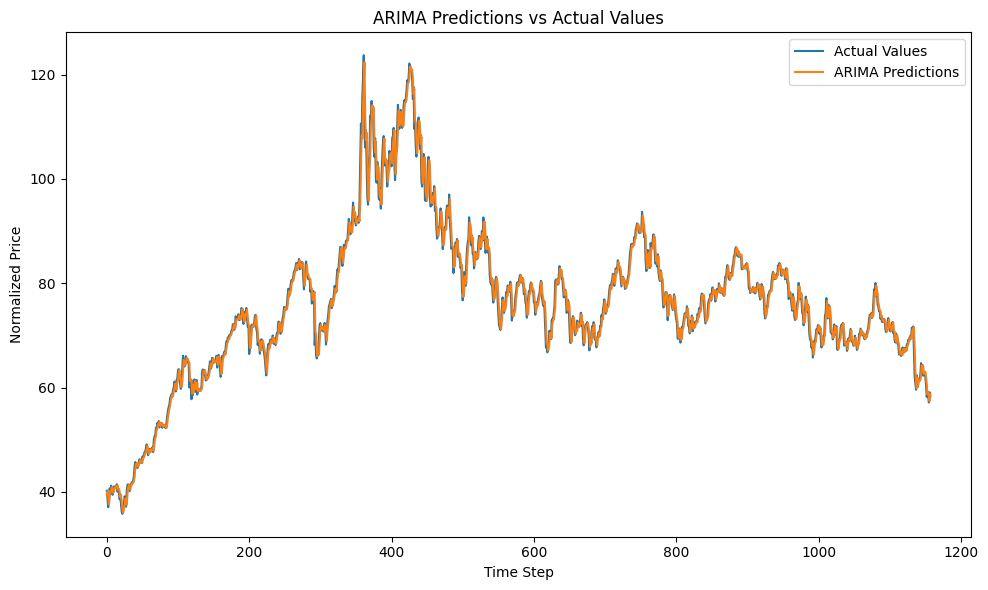

In [25]:
#TO DO: Plot ARIMA vs actual
plot_predictions(arima_preds, arima_gt, "ARIMA")

In [26]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
order_combinations = [(3,1,2)]
seasonal_combinations = [(3,1,1,12)]
# Initialize variables to store the best results
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# Grid search over all parameter combinations
for order in order_combinations:
    for seasonal_order in seasonal_combinations:
        try:
            #TO DO: Train SARIMA model
            sarima = SARIMAX(
                train_target,
                exog=train_exog,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
        
            #TO DO: Check AIC
            aic = sarima.aic
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = sarima

        except Exception as e:
            print(e)
            continue

print(f"Best SARIMA Model: Order={best_order}, Seasonal_Order={best_seasonal_order}, AIC={best_aic}")
print(best_model.summary())

Best SARIMA Model: Order=(3, 1, 2), Seasonal_Order=None, AIC=5523.1351126676
                                      SARIMAX Results                                       
Dep. Variable:                            Adj Close   No. Observations:                 2705
Model:             SARIMAX(3, 1, 2)x(3, 1, [1], 12)   Log Likelihood               -2747.568
Date:                              Thu, 08 May 2025   AIC                           5523.135
Time:                                      11:52:00   BIC                           5605.503
Sample:                                           0   HQIC                          5552.949
                                             - 2705                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.7719

In [27]:
#TO DO: Batch forecasting for SARIMA
sarima_preds = best_model.forecast(steps=len(test_exog), exog=test_exog).values
sarima_gt = test_target.values
print("SARIMA Metrics (Unscaled):", calculate_metrics(sarima_preds, sarima_gt))

SARIMA Metrics (Unscaled): (6.096667589246655, 5.037192916871215, 0.8294043583613677, 6.1455201059241915)


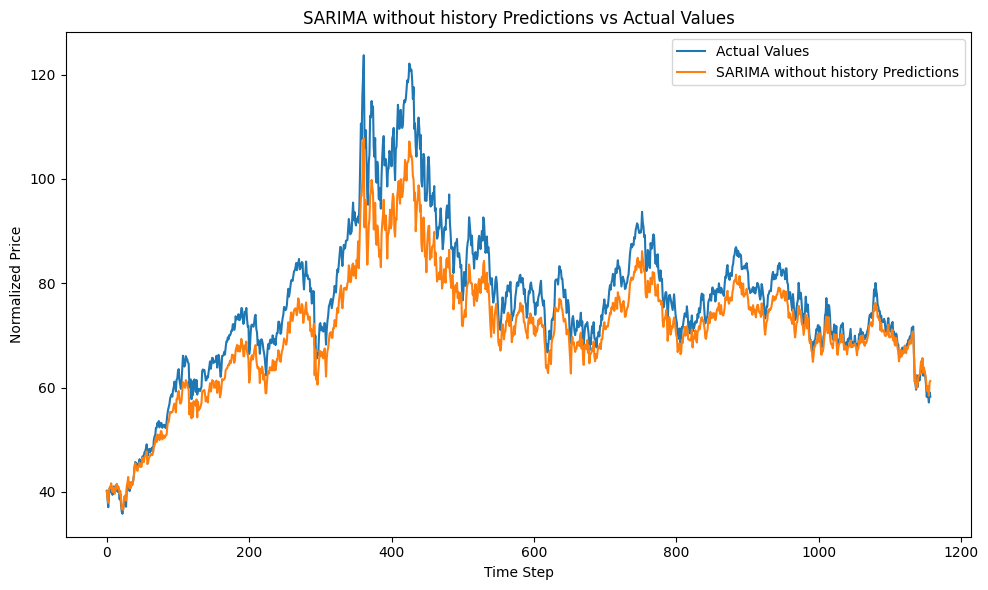

In [28]:
#TO DO: Plot SARIMA vs actual
plot_predictions(sarima_preds, sarima_gt, "SARIMA without history")

<font color='cyan'>

### Conclusion

We evaluated several models including ARIMA, SARIMA, RNN, LSTM, and GRU for this task (which was **predicting crude oil prices**). Below is a comparison of their performance on unscaled test data:

| Model   | RMSE    | MAE     | R²       | MAPE    |
|---------|---------|---------|----------|---------|
| ARIMA   | 1.968   | 1.415   | 0.982    | 1.829%  |
| SARIMA  | 6.097   | 5.037   | 0.829    | 6.146%  |
| RNN     | 0.136   | 0.114   | -0.428   | 20.701% |
| LSTM    | 0.058   | 0.048   | 0.745    | 7.539%  |
| GRU     | 0.068   | 0.059   | 0.649    | 9.490%  |

---

- **ARIMA** performed surprisingly well in terms of traditional metrics like R² and MAPE. It captured long-term trends effectively, especially when prices were relatively stable. However, it may **underperform in highly nonlinear or volatile periods** due to its linear nature(we have explained its disadvantages before).

- **SARIMA** was expected to improve upon ARIMA by incorporating seasonal patterns (e.g., annual cycles), but in this dataset it **underperformed significantly** possibly due to weak or inconsistent seasonality in crude oil prices. This highlights a **limitation of SARIMA** when seasonality is not dominant or consistent. (It was also quite obvious because there isn't really a periodic pattern in crude oil prices)

- **RNN** performed poorly with a **negative R²**, indicating that it failed to generalize and likely **overfit or failed to capture complex patterns**, possibly due to its limited memory and sensitivity to vanishing gradients.

- **LSTM** was the **best overall performer**, achieving the **lowest RMSE and MAE**, and a strong **positive R² (0.745)**. Its ability to remember long-term dependencies makes it well-suited to the complex, nonlinear behavior of oil prices.

- **GRU** also performed well, though slightly behind LSTM. It is computationally lighter and still captured most of the nonlinear structure, making it a **good trade-off between performance and efficiency**.

---

### Comparison w/ the paper

Overall we can say that we have generated the same results as the paper (at least in most of the cases). Of course the paper had multiple datasets, and thus was able to compare different methods on different datasets and provided us w/ a cleaner and more accurate comparison, but assuming this is the only datasets that we have, we can say that we have reproduced paper's results quite well. Because we both have concluded that new methods like LSTM and GRU are much better than RNN, and besides them, classic methods like ARIMA and SARIMA (especially ARIMA) can perform as well as LSTM or even better on some cases. We should keep in mind that the differences between the paper's and our losses are due to different datasets, structures, etc. that the paper has but we don't.

